##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 4202496/68606236 [>.............................] - ETA: 1s

 9060352/68606236 [==>...........................] - ETA: 0s

14614528/68606236 [=====>........................] - ETA: 0s

20242432/68606236 [=======>......................] - ETA: 0s

25862144/68606236 [==========>...................] - ETA: 0s

31481856/68606236 [============>.................] - ETA: 0s

37101568/68606236 [===============>..............] - ETA: 0s

42721280/68606236 [=================>............] - ETA: 0s

48340992/68606236 [====================>.........] - ETA: 0s

53846016/68606236 [======================>.......] - ETA: 0s

64135168/68606236 [===========================>..] - ETA: 0s

68608000/68606236 [==============================] - 1s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

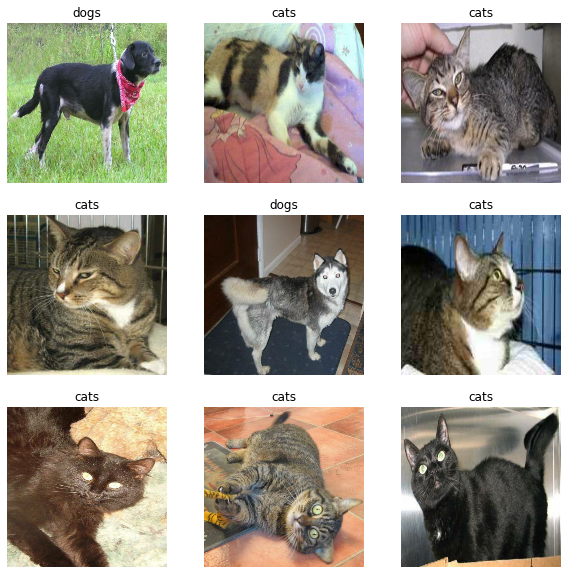

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

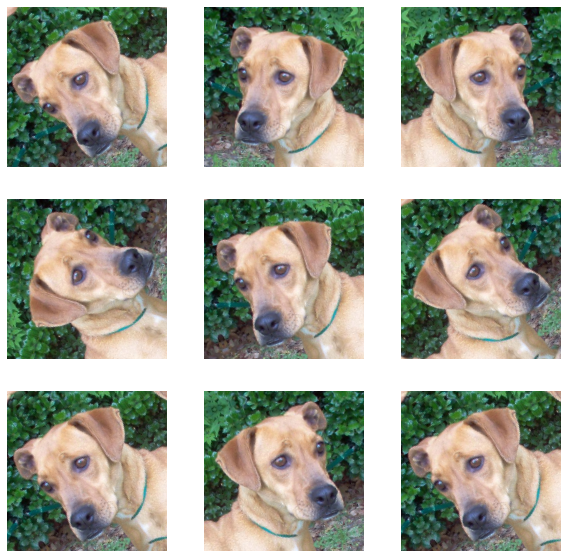

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

5308416/9406464 [===============>..............] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 44s - loss: 0.6467 - accuracy: 0.6250

 4/26 [===>..........................] - ETA: 0s - loss: 0.6741 - accuracy: 0.5885 

 6/26 [=====>........................] - ETA: 0s - loss: 0.6886 - accuracy: 0.5837

 8/26 [========>.....................] - ETA: 0s - loss: 0.6935 - accuracy: 0.5773

10/26 [==========>...................] - ETA: 0s - loss: 0.7005 - accuracy: 0.5685

12/26 [============>.................] - ETA: 0s - loss: 0.7064 - accuracy: 0.5614

14/26 [===============>..............] - ETA: 0s - loss: 0.7132 - accuracy: 0.5546

16/26 [=================>............] - ETA: 0s - loss: 0.7174 - accuracy: 0.5501

18/26 [===================>..........] - ETA: 0s - loss: 0.7202 - accuracy: 0.5461

23/26 [=========================>....] - ETA: 0s - loss: 0.7279 - accuracy: 0.5379

26/26 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.5355

26/26 [==============================] - 3s 31ms/step - loss: 0.7321 - accuracy: 0.5349


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.52


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:48 - loss: 0.7111 - accuracy: 0.5625

 3/63 [>.............................] - ETA: 2s - loss: 0.8261 - accuracy: 0.4896  

 5/63 [=>............................] - ETA: 2s - loss: 0.7520 - accuracy: 0.5500

 7/63 [==>...........................] - ETA: 2s - loss: 0.7548 - accuracy: 0.5402

 9/63 [===>..........................] - ETA: 2s - loss: 0.7440 - accuracy: 0.5556

11/63 [====>.........................] - ETA: 1s - loss: 0.7420 - accuracy: 0.5597

13/63 [=====>........................] - ETA: 1s - loss: 0.7361 - accuracy: 0.5601

15/63 [======>.......................] - ETA: 1s - loss: 0.7310 - accuracy: 0.5604

17/63 [=======>......................] - ETA: 1s - loss: 0.7275 - accuracy: 0.5588

19/63 [========>.....................] - ETA: 1s - loss: 0.7231 - accuracy: 0.5592

21/63 [=========>....................] - ETA: 1s - loss: 0.7209 - accuracy: 0.5580

23/63 [=========>....................] - ETA: 1s - loss: 0.7193 - accuracy: 0.5598

25/63 [==========>...................] - ETA: 1s - loss: 0.7149 - accuracy: 0.5625

27/63 [===========>..................] - ETA: 1s - loss: 0.7085 - accuracy: 0.5729

29/63 [============>.................] - ETA: 1s - loss: 0.7054 - accuracy: 0.5776

31/63 [=============>................] - ETA: 1s - loss: 0.6992 - accuracy: 0.5796

33/63 [==============>...............] - ETA: 1s - loss: 0.6922 - accuracy: 0.5843

35/63 [===============>..............] - ETA: 1s - loss: 0.6855 - accuracy: 0.5893

37/63 [================>.............] - ETA: 0s - loss: 0.6797 - accuracy: 0.5988

39/63 [=================>............] - ETA: 0s - loss: 0.6744 - accuracy: 0.6018

41/63 [==================>...........] - ETA: 0s - loss: 0.6663 - accuracy: 0.6082

43/63 [===================>..........] - ETA: 0s - loss: 0.6622 - accuracy: 0.6112

45/63 [====================>.........] - ETA: 0s - loss: 0.6551 - accuracy: 0.6174

47/63 [=====================>........] - ETA: 0s - loss: 0.6562 - accuracy: 0.6150

49/63 [======================>.......] - ETA: 0s - loss: 0.6546 - accuracy: 0.6173

51/63 [=======================>......] - ETA: 0s - loss: 0.6530 - accuracy: 0.6189

53/63 [========================>.....] - ETA: 0s - loss: 0.6480 - accuracy: 0.6250

55/63 [=========================>....] - ETA: 0s - loss: 0.6464 - accuracy: 0.6261

59/63 [===========================>..] - ETA: 0s - loss: 0.6420 - accuracy: 0.6287

63/63 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.6295

63/63 [==============================] - 6s 59ms/step - loss: 0.6367 - accuracy: 0.6295 - val_loss: 0.5070 - val_accuracy: 0.7092


Epoch 2/10


 1/63 [..............................] - ETA: 19s - loss: 0.5363 - accuracy: 0.6875

 3/63 [>.............................] - ETA: 2s - loss: 0.6156 - accuracy: 0.6250 

 5/63 [=>............................] - ETA: 1s - loss: 0.5996 - accuracy: 0.6625

 7/63 [==>...........................] - ETA: 1s - loss: 0.5930 - accuracy: 0.6562

 9/63 [===>..........................] - ETA: 1s - loss: 0.6009 - accuracy: 0.6424

11/63 [====>.........................] - ETA: 1s - loss: 0.5782 - accuracy: 0.6534

13/63 [=====>........................] - ETA: 1s - loss: 0.5570 - accuracy: 0.6731

15/63 [======>.......................] - ETA: 1s - loss: 0.5485 - accuracy: 0.6771

17/63 [=======>......................] - ETA: 1s - loss: 0.5494 - accuracy: 0.6783

19/63 [========>.....................] - ETA: 1s - loss: 0.5477 - accuracy: 0.6776

21/63 [=========>....................] - ETA: 1s - loss: 0.5524 - accuracy: 0.6711

23/63 [=========>....................] - ETA: 1s - loss: 0.5439 - accuracy: 0.6821

25/63 [==========>...................] - ETA: 1s - loss: 0.5479 - accuracy: 0.6850

27/63 [===========>..................] - ETA: 1s - loss: 0.5508 - accuracy: 0.6829

29/63 [============>.................] - ETA: 1s - loss: 0.5439 - accuracy: 0.6886

31/63 [=============>................] - ETA: 1s - loss: 0.5431 - accuracy: 0.6935

33/63 [==============>...............] - ETA: 1s - loss: 0.5346 - accuracy: 0.6998

35/63 [===============>..............] - ETA: 0s - loss: 0.5286 - accuracy: 0.7054

37/63 [================>.............] - ETA: 0s - loss: 0.5236 - accuracy: 0.7078

39/63 [=================>............] - ETA: 0s - loss: 0.5230 - accuracy: 0.7115

41/63 [==================>...........] - ETA: 0s - loss: 0.5208 - accuracy: 0.7142

43/63 [===================>..........] - ETA: 0s - loss: 0.5163 - accuracy: 0.7173

45/63 [====================>.........] - ETA: 0s - loss: 0.5126 - accuracy: 0.7236

47/63 [=====================>........] - ETA: 0s - loss: 0.5072 - accuracy: 0.7294

49/63 [======================>.......] - ETA: 0s - loss: 0.5039 - accuracy: 0.7315

51/63 [=======================>......] - ETA: 0s - loss: 0.4975 - accuracy: 0.7371

53/63 [========================>.....] - ETA: 0s - loss: 0.5001 - accuracy: 0.7347

55/63 [=========================>....] - ETA: 0s - loss: 0.4986 - accuracy: 0.7352

60/63 [===========================>..] - ETA: 0s - loss: 0.4935 - accuracy: 0.7411

63/63 [==============================] - 3s 51ms/step - loss: 0.4911 - accuracy: 0.7415 - val_loss: 0.3708 - val_accuracy: 0.8218


Epoch 3/10


 1/63 [..............................] - ETA: 17s - loss: 0.3958 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 2s - loss: 0.3991 - accuracy: 0.7917 

 5/63 [=>............................] - ETA: 1s - loss: 0.4133 - accuracy: 0.7625

 7/63 [==>...........................] - ETA: 1s - loss: 0.4170 - accuracy: 0.7545

 9/63 [===>..........................] - ETA: 1s - loss: 0.3991 - accuracy: 0.7812

11/63 [====>.........................] - ETA: 1s - loss: 0.4152 - accuracy: 0.7670

13/63 [=====>........................] - ETA: 1s - loss: 0.4226 - accuracy: 0.7620

15/63 [======>.......................] - ETA: 1s - loss: 0.4127 - accuracy: 0.7708

17/63 [=======>......................] - ETA: 1s - loss: 0.4302 - accuracy: 0.7665

19/63 [========>.....................] - ETA: 1s - loss: 0.4337 - accuracy: 0.7615

21/63 [=========>....................] - ETA: 1s - loss: 0.4355 - accuracy: 0.7679

23/63 [=========>....................] - ETA: 1s - loss: 0.4385 - accuracy: 0.7690

25/63 [==========>...................] - ETA: 1s - loss: 0.4369 - accuracy: 0.7663

27/63 [===========>..................] - ETA: 1s - loss: 0.4380 - accuracy: 0.7674

29/63 [============>.................] - ETA: 1s - loss: 0.4384 - accuracy: 0.7694

31/63 [=============>................] - ETA: 1s - loss: 0.4277 - accuracy: 0.7802

33/63 [==============>...............] - ETA: 0s - loss: 0.4234 - accuracy: 0.7831

35/63 [===============>..............] - ETA: 0s - loss: 0.4195 - accuracy: 0.7866

37/63 [================>.............] - ETA: 0s - loss: 0.4186 - accuracy: 0.7880

39/63 [=================>............] - ETA: 0s - loss: 0.4125 - accuracy: 0.7941

41/63 [==================>...........] - ETA: 0s - loss: 0.4114 - accuracy: 0.7973

43/63 [===================>..........] - ETA: 0s - loss: 0.4125 - accuracy: 0.7980

45/63 [====================>.........] - ETA: 0s - loss: 0.4121 - accuracy: 0.7986

47/63 [=====================>........] - ETA: 0s - loss: 0.4082 - accuracy: 0.8019

49/63 [======================>.......] - ETA: 0s - loss: 0.4069 - accuracy: 0.8042

51/63 [=======================>......] - ETA: 0s - loss: 0.4063 - accuracy: 0.8027

53/63 [========================>.....] - ETA: 0s - loss: 0.4056 - accuracy: 0.8037

55/63 [=========================>....] - ETA: 0s - loss: 0.4016 - accuracy: 0.8062

60/63 [===========================>..] - ETA: 0s - loss: 0.4002 - accuracy: 0.8073

63/63 [==============================] - 3s 48ms/step - loss: 0.4033 - accuracy: 0.8080 - val_loss: 0.2846 - val_accuracy: 0.8899


Epoch 4/10


 1/63 [..............................] - ETA: 19s - loss: 0.4223 - accuracy: 0.7500

 3/63 [>.............................] - ETA: 2s - loss: 0.3424 - accuracy: 0.8229 

 5/63 [=>............................] - ETA: 2s - loss: 0.3377 - accuracy: 0.8188

 7/63 [==>...........................] - ETA: 1s - loss: 0.3575 - accuracy: 0.8125

 9/63 [===>..........................] - ETA: 1s - loss: 0.3655 - accuracy: 0.8090

11/63 [====>.........................] - ETA: 1s - loss: 0.3739 - accuracy: 0.8125

13/63 [=====>........................] - ETA: 1s - loss: 0.3745 - accuracy: 0.8077

15/63 [======>.......................] - ETA: 1s - loss: 0.3673 - accuracy: 0.8062

17/63 [=======>......................] - ETA: 1s - loss: 0.3681 - accuracy: 0.8051

19/63 [========>.....................] - ETA: 1s - loss: 0.3581 - accuracy: 0.8109

21/63 [=========>....................] - ETA: 1s - loss: 0.3547 - accuracy: 0.8140

23/63 [=========>....................] - ETA: 1s - loss: 0.3559 - accuracy: 0.8111

25/63 [==========>...................] - ETA: 1s - loss: 0.3513 - accuracy: 0.8200

27/63 [===========>..................] - ETA: 1s - loss: 0.3511 - accuracy: 0.8229

29/63 [============>.................] - ETA: 1s - loss: 0.3617 - accuracy: 0.8168

31/63 [=============>................] - ETA: 1s - loss: 0.3586 - accuracy: 0.8206

33/63 [==============>...............] - ETA: 1s - loss: 0.3591 - accuracy: 0.8201

35/63 [===============>..............] - ETA: 1s - loss: 0.3534 - accuracy: 0.8250

37/63 [================>.............] - ETA: 0s - loss: 0.3531 - accuracy: 0.8260

39/63 [=================>............] - ETA: 0s - loss: 0.3538 - accuracy: 0.8269

41/63 [==================>...........] - ETA: 0s - loss: 0.3557 - accuracy: 0.8270

43/63 [===================>..........] - ETA: 0s - loss: 0.3544 - accuracy: 0.8285

45/63 [====================>.........] - ETA: 0s - loss: 0.3500 - accuracy: 0.8319

47/63 [=====================>........] - ETA: 0s - loss: 0.3467 - accuracy: 0.8338

49/63 [======================>.......] - ETA: 0s - loss: 0.3444 - accuracy: 0.8367

51/63 [=======================>......] - ETA: 0s - loss: 0.3413 - accuracy: 0.8388

53/63 [========================>.....] - ETA: 0s - loss: 0.3438 - accuracy: 0.8373

55/63 [=========================>....] - ETA: 0s - loss: 0.3430 - accuracy: 0.8381

60/63 [===========================>..] - ETA: 0s - loss: 0.3422 - accuracy: 0.8391

63/63 [==============================] - 4s 52ms/step - loss: 0.3427 - accuracy: 0.8385 - val_loss: 0.2322 - val_accuracy: 0.9220


Epoch 5/10


 1/63 [..............................] - ETA: 18s - loss: 0.3244 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 2s - loss: 0.3394 - accuracy: 0.8646 

 5/63 [=>............................] - ETA: 1s - loss: 0.3237 - accuracy: 0.8687

 7/63 [==>...........................] - ETA: 1s - loss: 0.3430 - accuracy: 0.8527

 9/63 [===>..........................] - ETA: 1s - loss: 0.3285 - accuracy: 0.8438

11/63 [====>.........................] - ETA: 1s - loss: 0.3261 - accuracy: 0.8551

13/63 [=====>........................] - ETA: 1s - loss: 0.3256 - accuracy: 0.8606

15/63 [======>.......................] - ETA: 1s - loss: 0.3170 - accuracy: 0.8687

17/63 [=======>......................] - ETA: 1s - loss: 0.3175 - accuracy: 0.8676

19/63 [========>.....................] - ETA: 1s - loss: 0.3165 - accuracy: 0.8635

21/63 [=========>....................] - ETA: 1s - loss: 0.3140 - accuracy: 0.8631

23/63 [=========>....................] - ETA: 1s - loss: 0.3113 - accuracy: 0.8655

25/63 [==========>...................] - ETA: 1s - loss: 0.3134 - accuracy: 0.8637

27/63 [===========>..................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8657

29/63 [============>.................] - ETA: 1s - loss: 0.3087 - accuracy: 0.8664

31/63 [=============>................] - ETA: 1s - loss: 0.3046 - accuracy: 0.8710

33/63 [==============>...............] - ETA: 1s - loss: 0.3039 - accuracy: 0.8703

35/63 [===============>..............] - ETA: 0s - loss: 0.3016 - accuracy: 0.8714

37/63 [================>.............] - ETA: 0s - loss: 0.3013 - accuracy: 0.8733

39/63 [=================>............] - ETA: 0s - loss: 0.3010 - accuracy: 0.8726

41/63 [==================>...........] - ETA: 0s - loss: 0.3016 - accuracy: 0.8712

43/63 [===================>..........] - ETA: 0s - loss: 0.2975 - accuracy: 0.8750

45/63 [====================>.........] - ETA: 0s - loss: 0.2981 - accuracy: 0.8729

47/63 [=====================>........] - ETA: 0s - loss: 0.2968 - accuracy: 0.8737

49/63 [======================>.......] - ETA: 0s - loss: 0.3022 - accuracy: 0.8718

51/63 [=======================>......] - ETA: 0s - loss: 0.3043 - accuracy: 0.8683

53/63 [========================>.....] - ETA: 0s - loss: 0.3005 - accuracy: 0.8715

55/63 [=========================>....] - ETA: 0s - loss: 0.3000 - accuracy: 0.8705

60/63 [===========================>..] - ETA: 0s - loss: 0.2965 - accuracy: 0.8734

63/63 [==============================] - 3s 51ms/step - loss: 0.2967 - accuracy: 0.8725 - val_loss: 0.1984 - val_accuracy: 0.9356


Epoch 6/10


 1/63 [..............................] - ETA: 18s - loss: 0.1663 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.2129 - accuracy: 0.9062 

 5/63 [=>............................] - ETA: 1s - loss: 0.2333 - accuracy: 0.9000

 7/63 [==>...........................] - ETA: 1s - loss: 0.2266 - accuracy: 0.9018

 9/63 [===>..........................] - ETA: 1s - loss: 0.2659 - accuracy: 0.8750

11/63 [====>.........................] - ETA: 1s - loss: 0.2868 - accuracy: 0.8608

13/63 [=====>........................] - ETA: 1s - loss: 0.3149 - accuracy: 0.8534

15/63 [======>.......................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8583

17/63 [=======>......................] - ETA: 1s - loss: 0.3040 - accuracy: 0.8640

19/63 [========>.....................] - ETA: 1s - loss: 0.2971 - accuracy: 0.8684

21/63 [=========>....................] - ETA: 1s - loss: 0.2958 - accuracy: 0.8676

23/63 [=========>....................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8668

25/63 [==========>...................] - ETA: 1s - loss: 0.2911 - accuracy: 0.8687

27/63 [===========>..................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8646

29/63 [============>.................] - ETA: 1s - loss: 0.2881 - accuracy: 0.8696

31/63 [=============>................] - ETA: 1s - loss: 0.2862 - accuracy: 0.8720

33/63 [==============>...............] - ETA: 1s - loss: 0.2835 - accuracy: 0.8750

35/63 [===============>..............] - ETA: 0s - loss: 0.2831 - accuracy: 0.8759

37/63 [================>.............] - ETA: 0s - loss: 0.2801 - accuracy: 0.8775

39/63 [=================>............] - ETA: 0s - loss: 0.2785 - accuracy: 0.8798

41/63 [==================>...........] - ETA: 0s - loss: 0.2773 - accuracy: 0.8819

43/63 [===================>..........] - ETA: 0s - loss: 0.2749 - accuracy: 0.8823

45/63 [====================>.........] - ETA: 0s - loss: 0.2733 - accuracy: 0.8826

47/63 [=====================>........] - ETA: 0s - loss: 0.2729 - accuracy: 0.8830

49/63 [======================>.......] - ETA: 0s - loss: 0.2707 - accuracy: 0.8846

51/63 [=======================>......] - ETA: 0s - loss: 0.2701 - accuracy: 0.8860

53/63 [========================>.....] - ETA: 0s - loss: 0.2702 - accuracy: 0.8862

55/63 [=========================>....] - ETA: 0s - loss: 0.2681 - accuracy: 0.8881

60/63 [===========================>..] - ETA: 0s - loss: 0.2667 - accuracy: 0.8865

63/63 [==============================] - 3s 49ms/step - loss: 0.2658 - accuracy: 0.8880 - val_loss: 0.1714 - val_accuracy: 0.9455


Epoch 7/10


 1/63 [..............................] - ETA: 18s - loss: 0.2112 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 2s - loss: 0.2768 - accuracy: 0.8750 

 5/63 [=>............................] - ETA: 1s - loss: 0.2575 - accuracy: 0.8938

 7/63 [==>...........................] - ETA: 1s - loss: 0.2693 - accuracy: 0.8616

 9/63 [===>..........................] - ETA: 1s - loss: 0.2563 - accuracy: 0.8681

11/63 [====>.........................] - ETA: 1s - loss: 0.2567 - accuracy: 0.8693

13/63 [=====>........................] - ETA: 1s - loss: 0.2517 - accuracy: 0.8750

15/63 [======>.......................] - ETA: 1s - loss: 0.2537 - accuracy: 0.8729

17/63 [=======>......................] - ETA: 1s - loss: 0.2532 - accuracy: 0.8750

19/63 [========>.....................] - ETA: 1s - loss: 0.2518 - accuracy: 0.8750

21/63 [=========>....................] - ETA: 1s - loss: 0.2498 - accuracy: 0.8795

23/63 [=========>....................] - ETA: 1s - loss: 0.2610 - accuracy: 0.8736

25/63 [==========>...................] - ETA: 1s - loss: 0.2642 - accuracy: 0.8700

27/63 [===========>..................] - ETA: 1s - loss: 0.2656 - accuracy: 0.8692

29/63 [============>.................] - ETA: 1s - loss: 0.2662 - accuracy: 0.8718

31/63 [=============>................] - ETA: 1s - loss: 0.2631 - accuracy: 0.8740

33/63 [==============>...............] - ETA: 1s - loss: 0.2564 - accuracy: 0.8788

35/63 [===============>..............] - ETA: 0s - loss: 0.2534 - accuracy: 0.8804

37/63 [================>.............] - ETA: 0s - loss: 0.2517 - accuracy: 0.8818

39/63 [=================>............] - ETA: 0s - loss: 0.2536 - accuracy: 0.8814

41/63 [==================>...........] - ETA: 0s - loss: 0.2542 - accuracy: 0.8826

43/63 [===================>..........] - ETA: 0s - loss: 0.2511 - accuracy: 0.8844

45/63 [====================>.........] - ETA: 0s - loss: 0.2507 - accuracy: 0.8840

47/63 [=====================>........] - ETA: 0s - loss: 0.2521 - accuracy: 0.8830

49/63 [======================>.......] - ETA: 0s - loss: 0.2499 - accuracy: 0.8846

51/63 [=======================>......] - ETA: 0s - loss: 0.2483 - accuracy: 0.8860

53/63 [========================>.....] - ETA: 0s - loss: 0.2449 - accuracy: 0.8897

55/63 [=========================>....] - ETA: 0s - loss: 0.2457 - accuracy: 0.8886

60/63 [===========================>..] - ETA: 0s - loss: 0.2460 - accuracy: 0.8896

63/63 [==============================] - 3s 50ms/step - loss: 0.2503 - accuracy: 0.8880 - val_loss: 0.1592 - val_accuracy: 0.9517


Epoch 8/10


 1/63 [..............................] - ETA: 18s - loss: 0.2636 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.2391 - accuracy: 0.9167 

 5/63 [=>............................] - ETA: 1s - loss: 0.2572 - accuracy: 0.8938

 7/63 [==>...........................] - ETA: 1s - loss: 0.2766 - accuracy: 0.8616

 9/63 [===>..........................] - ETA: 1s - loss: 0.2712 - accuracy: 0.8646

11/63 [====>.........................] - ETA: 1s - loss: 0.2670 - accuracy: 0.8636

13/63 [=====>........................] - ETA: 1s - loss: 0.2794 - accuracy: 0.8726

15/63 [======>.......................] - ETA: 1s - loss: 0.2815 - accuracy: 0.8667

17/63 [=======>......................] - ETA: 1s - loss: 0.2768 - accuracy: 0.8695

19/63 [========>.....................] - ETA: 1s - loss: 0.2713 - accuracy: 0.8766

21/63 [=========>....................] - ETA: 1s - loss: 0.2641 - accuracy: 0.8839

23/63 [=========>....................] - ETA: 1s - loss: 0.2620 - accuracy: 0.8832

25/63 [==========>...................] - ETA: 1s - loss: 0.2626 - accuracy: 0.8813

27/63 [===========>..................] - ETA: 1s - loss: 0.2613 - accuracy: 0.8808

29/63 [============>.................] - ETA: 1s - loss: 0.2558 - accuracy: 0.8869

31/63 [=============>................] - ETA: 1s - loss: 0.2506 - accuracy: 0.8891

33/63 [==============>...............] - ETA: 1s - loss: 0.2496 - accuracy: 0.8920

35/63 [===============>..............] - ETA: 0s - loss: 0.2472 - accuracy: 0.8938

37/63 [================>.............] - ETA: 0s - loss: 0.2516 - accuracy: 0.8910

39/63 [=================>............] - ETA: 0s - loss: 0.2502 - accuracy: 0.8902

41/63 [==================>...........] - ETA: 0s - loss: 0.2476 - accuracy: 0.8933

43/63 [===================>..........] - ETA: 0s - loss: 0.2485 - accuracy: 0.8939

45/63 [====================>.........] - ETA: 0s - loss: 0.2483 - accuracy: 0.8938

47/63 [=====================>........] - ETA: 0s - loss: 0.2464 - accuracy: 0.8936

49/63 [======================>.......] - ETA: 0s - loss: 0.2442 - accuracy: 0.8960

51/63 [=======================>......] - ETA: 0s - loss: 0.2462 - accuracy: 0.8977

53/63 [========================>.....] - ETA: 0s - loss: 0.2450 - accuracy: 0.8974

55/63 [=========================>....] - ETA: 0s - loss: 0.2410 - accuracy: 0.9000

60/63 [===========================>..] - ETA: 0s - loss: 0.2415 - accuracy: 0.8974

63/63 [==============================] - 3s 49ms/step - loss: 0.2422 - accuracy: 0.8955 - val_loss: 0.1412 - val_accuracy: 0.9554


Epoch 9/10


 1/63 [..............................] - ETA: 17s - loss: 0.2359 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.2056 - accuracy: 0.9271 

 5/63 [=>............................] - ETA: 1s - loss: 0.2186 - accuracy: 0.9125

 7/63 [==>...........................] - ETA: 1s - loss: 0.2216 - accuracy: 0.8973

 9/63 [===>..........................] - ETA: 1s - loss: 0.2454 - accuracy: 0.8819

11/63 [====>.........................] - ETA: 1s - loss: 0.2433 - accuracy: 0.8864

13/63 [=====>........................] - ETA: 1s - loss: 0.2397 - accuracy: 0.8822

15/63 [======>.......................] - ETA: 1s - loss: 0.2306 - accuracy: 0.8917

17/63 [=======>......................] - ETA: 1s - loss: 0.2275 - accuracy: 0.8915

19/63 [========>.....................] - ETA: 1s - loss: 0.2200 - accuracy: 0.8964

21/63 [=========>....................] - ETA: 1s - loss: 0.2190 - accuracy: 0.8973

23/63 [=========>....................] - ETA: 1s - loss: 0.2269 - accuracy: 0.8899

25/63 [==========>...................] - ETA: 1s - loss: 0.2201 - accuracy: 0.8988

27/63 [===========>..................] - ETA: 1s - loss: 0.2181 - accuracy: 0.8993

29/63 [============>.................] - ETA: 1s - loss: 0.2180 - accuracy: 0.8998

31/63 [=============>................] - ETA: 1s - loss: 0.2143 - accuracy: 0.9052

33/63 [==============>...............] - ETA: 1s - loss: 0.2175 - accuracy: 0.9053

35/63 [===============>..............] - ETA: 0s - loss: 0.2121 - accuracy: 0.9098

37/63 [================>.............] - ETA: 0s - loss: 0.2103 - accuracy: 0.9113

39/63 [=================>............] - ETA: 0s - loss: 0.2116 - accuracy: 0.9103

41/63 [==================>...........] - ETA: 0s - loss: 0.2116 - accuracy: 0.9108

43/63 [===================>..........] - ETA: 0s - loss: 0.2120 - accuracy: 0.9113

45/63 [====================>.........] - ETA: 0s - loss: 0.2107 - accuracy: 0.9139

47/63 [=====================>........] - ETA: 0s - loss: 0.2116 - accuracy: 0.9136

49/63 [======================>.......] - ETA: 0s - loss: 0.2115 - accuracy: 0.9139

51/63 [=======================>......] - ETA: 0s - loss: 0.2134 - accuracy: 0.9136

53/63 [========================>.....] - ETA: 0s - loss: 0.2119 - accuracy: 0.9145

55/63 [=========================>....] - ETA: 0s - loss: 0.2111 - accuracy: 0.9142

60/63 [===========================>..] - ETA: 0s - loss: 0.2118 - accuracy: 0.9099

63/63 [==============================] - 3s 49ms/step - loss: 0.2124 - accuracy: 0.9100 - val_loss: 0.1308 - val_accuracy: 0.9604


Epoch 10/10


 1/63 [..............................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 2s - loss: 0.2411 - accuracy: 0.8854 

 5/63 [=>............................] - ETA: 1s - loss: 0.2465 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.2456 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 1s - loss: 0.2318 - accuracy: 0.8924

11/63 [====>.........................] - ETA: 1s - loss: 0.2485 - accuracy: 0.8864

13/63 [=====>........................] - ETA: 1s - loss: 0.2479 - accuracy: 0.8942

15/63 [======>.......................] - ETA: 1s - loss: 0.2402 - accuracy: 0.8938

17/63 [=======>......................] - ETA: 1s - loss: 0.2457 - accuracy: 0.8879

19/63 [========>.....................] - ETA: 1s - loss: 0.2410 - accuracy: 0.8914

21/63 [=========>....................] - ETA: 1s - loss: 0.2337 - accuracy: 0.8973

23/63 [=========>....................] - ETA: 1s - loss: 0.2323 - accuracy: 0.8981

25/63 [==========>...................] - ETA: 1s - loss: 0.2311 - accuracy: 0.8988

27/63 [===========>..................] - ETA: 1s - loss: 0.2313 - accuracy: 0.8993

29/63 [============>.................] - ETA: 1s - loss: 0.2331 - accuracy: 0.8966

31/63 [=============>................] - ETA: 1s - loss: 0.2299 - accuracy: 0.8972

33/63 [==============>...............] - ETA: 1s - loss: 0.2271 - accuracy: 0.8996

35/63 [===============>..............] - ETA: 0s - loss: 0.2275 - accuracy: 0.9009

37/63 [================>.............] - ETA: 0s - loss: 0.2228 - accuracy: 0.9037

39/63 [=================>............] - ETA: 0s - loss: 0.2256 - accuracy: 0.9006

41/63 [==================>...........] - ETA: 0s - loss: 0.2261 - accuracy: 0.9002

43/63 [===================>..........] - ETA: 0s - loss: 0.2245 - accuracy: 0.9012

45/63 [====================>.........] - ETA: 0s - loss: 0.2254 - accuracy: 0.9014

47/63 [=====================>........] - ETA: 0s - loss: 0.2230 - accuracy: 0.9029

49/63 [======================>.......] - ETA: 0s - loss: 0.2229 - accuracy: 0.9031

51/63 [=======================>......] - ETA: 0s - loss: 0.2194 - accuracy: 0.9056

53/63 [========================>.....] - ETA: 0s - loss: 0.2203 - accuracy: 0.9051

55/63 [=========================>....] - ETA: 0s - loss: 0.2181 - accuracy: 0.9062

60/63 [===========================>..] - ETA: 0s - loss: 0.2196 - accuracy: 0.9062

63/63 [==============================] - 3s 49ms/step - loss: 0.2199 - accuracy: 0.9055 - val_loss: 0.1193 - val_accuracy: 0.9691


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

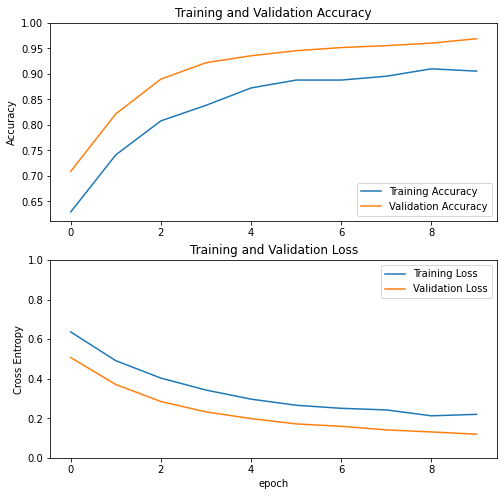

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:11 - loss: 0.1931 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.1675 - accuracy: 0.9514  

 5/63 [=>............................] - ETA: 1s - loss: 0.1626 - accuracy: 0.9486

 7/63 [==>...........................] - ETA: 1s - loss: 0.1754 - accuracy: 0.9462

 9/63 [===>..........................] - ETA: 1s - loss: 0.1837 - accuracy: 0.9419

11/63 [====>.........................] - ETA: 1s - loss: 0.1889 - accuracy: 0.9378

13/63 [=====>........................] - ETA: 1s - loss: 0.1909 - accuracy: 0.9353

15/63 [======>.......................] - ETA: 1s - loss: 0.1907 - accuracy: 0.9338

17/63 [=======>......................] - ETA: 1s - loss: 0.1901 - accuracy: 0.9328

19/63 [========>.....................] - ETA: 1s - loss: 0.1891 - accuracy: 0.9318

21/63 [=========>....................] - ETA: 1s - loss: 0.1880 - accuracy: 0.9308

23/63 [=========>....................] - ETA: 1s - loss: 0.1867 - accuracy: 0.9301

25/63 [==========>...................] - ETA: 1s - loss: 0.1853 - accuracy: 0.9297

27/63 [===========>..................] - ETA: 1s - loss: 0.1838 - accuracy: 0.9296

29/63 [============>.................] - ETA: 1s - loss: 0.1832 - accuracy: 0.9291

31/63 [=============>................] - ETA: 1s - loss: 0.1828 - accuracy: 0.9285

33/63 [==============>...............] - ETA: 1s - loss: 0.1825 - accuracy: 0.9278

35/63 [===============>..............] - ETA: 0s - loss: 0.1819 - accuracy: 0.9274

37/63 [================>.............] - ETA: 0s - loss: 0.1812 - accuracy: 0.9270

39/63 [=================>............] - ETA: 0s - loss: 0.1805 - accuracy: 0.9268

41/63 [==================>...........] - ETA: 0s - loss: 0.1799 - accuracy: 0.9266

43/63 [===================>..........] - ETA: 0s - loss: 0.1792 - accuracy: 0.9265

45/63 [====================>.........] - ETA: 0s - loss: 0.1785 - accuracy: 0.9265

47/63 [=====================>........] - ETA: 0s - loss: 0.1777 - accuracy: 0.9265

49/63 [======================>.......] - ETA: 0s - loss: 0.1769 - accuracy: 0.9266

51/63 [=======================>......] - ETA: 0s - loss: 0.1763 - accuracy: 0.9266

53/63 [========================>.....] - ETA: 0s - loss: 0.1757 - accuracy: 0.9266

56/63 [=========================>....] - ETA: 0s - loss: 0.1748 - accuracy: 0.9267

59/63 [===========================>..] - ETA: 0s - loss: 0.1741 - accuracy: 0.9269

62/63 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9270

63/63 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9271

63/63 [==============================] - 8s 65ms/step - loss: 0.1731 - accuracy: 0.9271 - val_loss: 0.0527 - val_accuracy: 0.9752


Epoch 11/20


 1/63 [..............................] - ETA: 19s - loss: 0.0788 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.0738 - accuracy: 0.9497 

 5/63 [=>............................] - ETA: 1s - loss: 0.0738 - accuracy: 0.9560

 7/63 [==>...........................] - ETA: 1s - loss: 0.0735 - accuracy: 0.9597

 9/63 [===>..........................] - ETA: 1s - loss: 0.0783 - accuracy: 0.9597

11/63 [====>.........................] - ETA: 1s - loss: 0.0833 - accuracy: 0.9575

13/63 [=====>........................] - ETA: 1s - loss: 0.0865 - accuracy: 0.9566

15/63 [======>.......................] - ETA: 1s - loss: 0.0925 - accuracy: 0.9553

17/63 [=======>......................] - ETA: 1s - loss: 0.0959 - accuracy: 0.9549

19/63 [========>.....................] - ETA: 1s - loss: 0.0979 - accuracy: 0.9549

21/63 [=========>....................] - ETA: 1s - loss: 0.0995 - accuracy: 0.9550

23/63 [=========>....................] - ETA: 1s - loss: 0.1008 - accuracy: 0.9552

25/63 [==========>...................] - ETA: 1s - loss: 0.1018 - accuracy: 0.9553

27/63 [===========>..................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9556

29/63 [============>.................] - ETA: 1s - loss: 0.1028 - accuracy: 0.9559

31/63 [=============>................] - ETA: 1s - loss: 0.1036 - accuracy: 0.9559

33/63 [==============>...............] - ETA: 1s - loss: 0.1040 - accuracy: 0.9559

35/63 [===============>..............] - ETA: 0s - loss: 0.1047 - accuracy: 0.9557

37/63 [================>.............] - ETA: 0s - loss: 0.1053 - accuracy: 0.9556

39/63 [=================>............] - ETA: 0s - loss: 0.1059 - accuracy: 0.9555

41/63 [==================>...........] - ETA: 0s - loss: 0.1064 - accuracy: 0.9554

43/63 [===================>..........] - ETA: 0s - loss: 0.1068 - accuracy: 0.9553

45/63 [====================>.........] - ETA: 0s - loss: 0.1072 - accuracy: 0.9552

47/63 [=====================>........] - ETA: 0s - loss: 0.1075 - accuracy: 0.9551

49/63 [======================>.......] - ETA: 0s - loss: 0.1079 - accuracy: 0.9550

51/63 [=======================>......] - ETA: 0s - loss: 0.1084 - accuracy: 0.9548

53/63 [========================>.....] - ETA: 0s - loss: 0.1089 - accuracy: 0.9546

55/63 [=========================>....] - ETA: 0s - loss: 0.1094 - accuracy: 0.9544

58/63 [==========================>...] - ETA: 0s - loss: 0.1101 - accuracy: 0.9540

61/63 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9538

63/63 [==============================] - 3s 50ms/step - loss: 0.1111 - accuracy: 0.9536 - val_loss: 0.0416 - val_accuracy: 0.9876


Epoch 12/20


 1/63 [..............................] - ETA: 18s - loss: 0.1865 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.1439 - accuracy: 0.9358 

 5/63 [=>............................] - ETA: 1s - loss: 0.1388 - accuracy: 0.9421

 7/63 [==>...........................] - ETA: 1s - loss: 0.1328 - accuracy: 0.9443

 9/63 [===>..........................] - ETA: 1s - loss: 0.1272 - accuracy: 0.9461

11/63 [====>.........................] - ETA: 1s - loss: 0.1230 - accuracy: 0.9477

13/63 [=====>........................] - ETA: 1s - loss: 0.1193 - accuracy: 0.9494

15/63 [======>.......................] - ETA: 1s - loss: 0.1167 - accuracy: 0.9504

17/63 [=======>......................] - ETA: 1s - loss: 0.1163 - accuracy: 0.9504

19/63 [========>.....................] - ETA: 1s - loss: 0.1167 - accuracy: 0.9499

21/63 [=========>....................] - ETA: 1s - loss: 0.1168 - accuracy: 0.9499

23/63 [=========>....................] - ETA: 1s - loss: 0.1168 - accuracy: 0.9498

25/63 [==========>...................] - ETA: 1s - loss: 0.1169 - accuracy: 0.9498

27/63 [===========>..................] - ETA: 1s - loss: 0.1170 - accuracy: 0.9499

29/63 [============>.................] - ETA: 1s - loss: 0.1171 - accuracy: 0.9500

31/63 [=============>................] - ETA: 1s - loss: 0.1169 - accuracy: 0.9501

33/63 [==============>...............] - ETA: 1s - loss: 0.1166 - accuracy: 0.9504

35/63 [===============>..............] - ETA: 0s - loss: 0.1162 - accuracy: 0.9507

37/63 [================>.............] - ETA: 0s - loss: 0.1160 - accuracy: 0.9509

39/63 [=================>............] - ETA: 0s - loss: 0.1160 - accuracy: 0.9511

41/63 [==================>...........] - ETA: 0s - loss: 0.1160 - accuracy: 0.9512

43/63 [===================>..........] - ETA: 0s - loss: 0.1159 - accuracy: 0.9512

45/63 [====================>.........] - ETA: 0s - loss: 0.1158 - accuracy: 0.9514

47/63 [=====================>........] - ETA: 0s - loss: 0.1157 - accuracy: 0.9515

49/63 [======================>.......] - ETA: 0s - loss: 0.1155 - accuracy: 0.9516

51/63 [=======================>......] - ETA: 0s - loss: 0.1154 - accuracy: 0.9516

53/63 [========================>.....] - ETA: 0s - loss: 0.1154 - accuracy: 0.9517

55/63 [=========================>....] - ETA: 0s - loss: 0.1154 - accuracy: 0.9517

58/63 [==========================>...] - ETA: 0s - loss: 0.1155 - accuracy: 0.9517

61/63 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9519

63/63 [==============================] - 3s 50ms/step - loss: 0.1153 - accuracy: 0.9520 - val_loss: 0.0446 - val_accuracy: 0.9814


Epoch 13/20


 1/63 [..............................] - ETA: 18s - loss: 0.0276 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0357 - accuracy: 0.9878 

 5/63 [=>............................] - ETA: 1s - loss: 0.0476 - accuracy: 0.9802

 7/63 [==>...........................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9749

 9/63 [===>..........................] - ETA: 1s - loss: 0.0643 - accuracy: 0.9727

11/63 [====>.........................] - ETA: 1s - loss: 0.0686 - accuracy: 0.9704

13/63 [=====>........................] - ETA: 1s - loss: 0.0718 - accuracy: 0.9686

15/63 [======>.......................] - ETA: 1s - loss: 0.0765 - accuracy: 0.9666

17/63 [=======>......................] - ETA: 1s - loss: 0.0796 - accuracy: 0.9655

19/63 [========>.....................] - ETA: 1s - loss: 0.0818 - accuracy: 0.9648

21/63 [=========>....................] - ETA: 1s - loss: 0.0832 - accuracy: 0.9643

23/63 [=========>....................] - ETA: 1s - loss: 0.0841 - accuracy: 0.9641

25/63 [==========>...................] - ETA: 1s - loss: 0.0845 - accuracy: 0.9641

27/63 [===========>..................] - ETA: 1s - loss: 0.0847 - accuracy: 0.9643

29/63 [============>.................] - ETA: 1s - loss: 0.0847 - accuracy: 0.9643

31/63 [=============>................] - ETA: 1s - loss: 0.0848 - accuracy: 0.9644

33/63 [==============>...............] - ETA: 1s - loss: 0.0849 - accuracy: 0.9645

35/63 [===============>..............] - ETA: 0s - loss: 0.0850 - accuracy: 0.9645

37/63 [================>.............] - ETA: 0s - loss: 0.0856 - accuracy: 0.9643

39/63 [=================>............] - ETA: 0s - loss: 0.0861 - accuracy: 0.9640

41/63 [==================>...........] - ETA: 0s - loss: 0.0868 - accuracy: 0.9637

43/63 [===================>..........] - ETA: 0s - loss: 0.0874 - accuracy: 0.9634

45/63 [====================>.........] - ETA: 0s - loss: 0.0880 - accuracy: 0.9631

47/63 [=====================>........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9629

49/63 [======================>.......] - ETA: 0s - loss: 0.0891 - accuracy: 0.9626

51/63 [=======================>......] - ETA: 0s - loss: 0.0895 - accuracy: 0.9624

53/63 [========================>.....] - ETA: 0s - loss: 0.0899 - accuracy: 0.9622

55/63 [=========================>....] - ETA: 0s - loss: 0.0902 - accuracy: 0.9621

58/63 [==========================>...] - ETA: 0s - loss: 0.0905 - accuracy: 0.9619

61/63 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9617

63/63 [==============================] - 3s 51ms/step - loss: 0.0909 - accuracy: 0.9615 - val_loss: 0.0354 - val_accuracy: 0.9814


Epoch 14/20


 1/63 [..............................] - ETA: 18s - loss: 0.0317 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0658 - accuracy: 0.9844 

 5/63 [=>............................] - ETA: 1s - loss: 0.0725 - accuracy: 0.9769

 7/63 [==>...........................] - ETA: 1s - loss: 0.0774 - accuracy: 0.9725

 9/63 [===>..........................] - ETA: 1s - loss: 0.0837 - accuracy: 0.9692

11/63 [====>.........................] - ETA: 1s - loss: 0.0862 - accuracy: 0.9678

13/63 [=====>........................] - ETA: 1s - loss: 0.0878 - accuracy: 0.9670

15/63 [======>.......................] - ETA: 1s - loss: 0.0906 - accuracy: 0.9655

17/63 [=======>......................] - ETA: 1s - loss: 0.0919 - accuracy: 0.9647

19/63 [========>.....................] - ETA: 1s - loss: 0.0934 - accuracy: 0.9640

21/63 [=========>....................] - ETA: 1s - loss: 0.0946 - accuracy: 0.9635

23/63 [=========>....................] - ETA: 1s - loss: 0.0950 - accuracy: 0.9632

25/63 [==========>...................] - ETA: 1s - loss: 0.0952 - accuracy: 0.9631

27/63 [===========>..................] - ETA: 1s - loss: 0.0954 - accuracy: 0.9630

29/63 [============>.................] - ETA: 1s - loss: 0.0953 - accuracy: 0.9630

31/63 [=============>................] - ETA: 1s - loss: 0.0950 - accuracy: 0.9630

33/63 [==============>...............] - ETA: 1s - loss: 0.0946 - accuracy: 0.9631

35/63 [===============>..............] - ETA: 0s - loss: 0.0944 - accuracy: 0.9631

37/63 [================>.............] - ETA: 0s - loss: 0.0943 - accuracy: 0.9632

39/63 [=================>............] - ETA: 0s - loss: 0.0940 - accuracy: 0.9632

41/63 [==================>...........] - ETA: 0s - loss: 0.0938 - accuracy: 0.9632

43/63 [===================>..........] - ETA: 0s - loss: 0.0936 - accuracy: 0.9632

45/63 [====================>.........] - ETA: 0s - loss: 0.0935 - accuracy: 0.9631

47/63 [=====================>........] - ETA: 0s - loss: 0.0935 - accuracy: 0.9630

49/63 [======================>.......] - ETA: 0s - loss: 0.0935 - accuracy: 0.9630

51/63 [=======================>......] - ETA: 0s - loss: 0.0936 - accuracy: 0.9628

53/63 [========================>.....] - ETA: 0s - loss: 0.0936 - accuracy: 0.9627

55/63 [=========================>....] - ETA: 0s - loss: 0.0936 - accuracy: 0.9627

58/63 [==========================>...] - ETA: 0s - loss: 0.0934 - accuracy: 0.9626

61/63 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9626

63/63 [==============================] - 3s 51ms/step - loss: 0.0932 - accuracy: 0.9626 - val_loss: 0.0327 - val_accuracy: 0.9851


Epoch 15/20


 1/63 [..............................] - ETA: 18s - loss: 0.0501 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0732 - accuracy: 0.9740 

 5/63 [=>............................] - ETA: 1s - loss: 0.0699 - accuracy: 0.9731

 7/63 [==>...........................] - ETA: 1s - loss: 0.0704 - accuracy: 0.9720

 9/63 [===>..........................] - ETA: 1s - loss: 0.0740 - accuracy: 0.9697

11/63 [====>.........................] - ETA: 1s - loss: 0.0777 - accuracy: 0.9671

13/63 [=====>........................] - ETA: 1s - loss: 0.0788 - accuracy: 0.9662

15/63 [======>.......................] - ETA: 1s - loss: 0.0787 - accuracy: 0.9659

17/63 [=======>......................] - ETA: 1s - loss: 0.0784 - accuracy: 0.9658

19/63 [========>.....................] - ETA: 1s - loss: 0.0786 - accuracy: 0.9659

21/63 [=========>....................] - ETA: 1s - loss: 0.0782 - accuracy: 0.9661

23/63 [=========>....................] - ETA: 1s - loss: 0.0780 - accuracy: 0.9663

25/63 [==========>...................] - ETA: 1s - loss: 0.0776 - accuracy: 0.9666

27/63 [===========>..................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9671

29/63 [============>.................] - ETA: 1s - loss: 0.0766 - accuracy: 0.9673

31/63 [=============>................] - ETA: 1s - loss: 0.0763 - accuracy: 0.9675

33/63 [==============>...............] - ETA: 1s - loss: 0.0759 - accuracy: 0.9677

35/63 [===============>..............] - ETA: 0s - loss: 0.0756 - accuracy: 0.9678

37/63 [================>.............] - ETA: 0s - loss: 0.0753 - accuracy: 0.9679

39/63 [=================>............] - ETA: 0s - loss: 0.0752 - accuracy: 0.9679

41/63 [==================>...........] - ETA: 0s - loss: 0.0753 - accuracy: 0.9679

43/63 [===================>..........] - ETA: 0s - loss: 0.0753 - accuracy: 0.9679

45/63 [====================>.........] - ETA: 0s - loss: 0.0754 - accuracy: 0.9679

47/63 [=====================>........] - ETA: 0s - loss: 0.0756 - accuracy: 0.9679

49/63 [======================>.......] - ETA: 0s - loss: 0.0757 - accuracy: 0.9680

51/63 [=======================>......] - ETA: 0s - loss: 0.0757 - accuracy: 0.9680

53/63 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9680

55/63 [=========================>....] - ETA: 0s - loss: 0.0760 - accuracy: 0.9680

58/63 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 0.9680

61/63 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9679

63/63 [==============================] - 3s 51ms/step - loss: 0.0765 - accuracy: 0.9679 - val_loss: 0.0353 - val_accuracy: 0.9827


Epoch 16/20


 1/63 [..............................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.0674 - accuracy: 0.9583 

 5/63 [=>............................] - ETA: 2s - loss: 0.0840 - accuracy: 0.9581

 7/63 [==>...........................] - ETA: 1s - loss: 0.0845 - accuracy: 0.9618

 9/63 [===>..........................] - ETA: 1s - loss: 0.0832 - accuracy: 0.9638

11/63 [====>.........................] - ETA: 1s - loss: 0.0820 - accuracy: 0.9647

13/63 [=====>........................] - ETA: 1s - loss: 0.0803 - accuracy: 0.9655

15/63 [======>.......................] - ETA: 1s - loss: 0.0783 - accuracy: 0.9664

17/63 [=======>......................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.0756 - accuracy: 0.9675

21/63 [=========>....................] - ETA: 1s - loss: 0.0745 - accuracy: 0.9681

23/63 [=========>....................] - ETA: 1s - loss: 0.0738 - accuracy: 0.9686

25/63 [==========>...................] - ETA: 1s - loss: 0.0730 - accuracy: 0.9692

27/63 [===========>..................] - ETA: 1s - loss: 0.0721 - accuracy: 0.9698

29/63 [============>.................] - ETA: 1s - loss: 0.0717 - accuracy: 0.9704

31/63 [=============>................] - ETA: 1s - loss: 0.0712 - accuracy: 0.9708

33/63 [==============>...............] - ETA: 1s - loss: 0.0708 - accuracy: 0.9712

35/63 [===============>..............] - ETA: 0s - loss: 0.0703 - accuracy: 0.9716

37/63 [================>.............] - ETA: 0s - loss: 0.0700 - accuracy: 0.9719

39/63 [=================>............] - ETA: 0s - loss: 0.0696 - accuracy: 0.9722

41/63 [==================>...........] - ETA: 0s - loss: 0.0693 - accuracy: 0.9724

43/63 [===================>..........] - ETA: 0s - loss: 0.0690 - accuracy: 0.9727

45/63 [====================>.........] - ETA: 0s - loss: 0.0687 - accuracy: 0.9729

47/63 [=====================>........] - ETA: 0s - loss: 0.0683 - accuracy: 0.9731

49/63 [======================>.......] - ETA: 0s - loss: 0.0679 - accuracy: 0.9733

51/63 [=======================>......] - ETA: 0s - loss: 0.0677 - accuracy: 0.9734

53/63 [========================>.....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9735

55/63 [=========================>....] - ETA: 0s - loss: 0.0674 - accuracy: 0.9736

58/63 [==========================>...] - ETA: 0s - loss: 0.0673 - accuracy: 0.9737

61/63 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9737

63/63 [==============================] - 3s 51ms/step - loss: 0.0670 - accuracy: 0.9738 - val_loss: 0.0354 - val_accuracy: 0.9851


Epoch 17/20


 1/63 [..............................] - ETA: 18s - loss: 0.1020 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.0708 - accuracy: 0.9618 

 5/63 [=>............................] - ETA: 1s - loss: 0.0702 - accuracy: 0.9646

 7/63 [==>...........................] - ETA: 1s - loss: 0.0685 - accuracy: 0.9672

 9/63 [===>..........................] - ETA: 1s - loss: 0.0666 - accuracy: 0.9691

11/63 [====>.........................] - ETA: 1s - loss: 0.0652 - accuracy: 0.9704

13/63 [=====>........................] - ETA: 1s - loss: 0.0643 - accuracy: 0.9717

15/63 [======>.......................] - ETA: 1s - loss: 0.0636 - accuracy: 0.9729

17/63 [=======>......................] - ETA: 1s - loss: 0.0630 - accuracy: 0.9739

19/63 [========>.....................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9746

21/63 [=========>....................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9750

23/63 [=========>....................] - ETA: 1s - loss: 0.0631 - accuracy: 0.9750

25/63 [==========>...................] - ETA: 1s - loss: 0.0637 - accuracy: 0.9748

27/63 [===========>..................] - ETA: 1s - loss: 0.0641 - accuracy: 0.9747

29/63 [============>.................] - ETA: 1s - loss: 0.0647 - accuracy: 0.9745

31/63 [=============>................] - ETA: 1s - loss: 0.0652 - accuracy: 0.9744

33/63 [==============>...............] - ETA: 1s - loss: 0.0658 - accuracy: 0.9742

35/63 [===============>..............] - ETA: 0s - loss: 0.0661 - accuracy: 0.9741

37/63 [================>.............] - ETA: 0s - loss: 0.0664 - accuracy: 0.9741

39/63 [=================>............] - ETA: 0s - loss: 0.0665 - accuracy: 0.9740

41/63 [==================>...........] - ETA: 0s - loss: 0.0666 - accuracy: 0.9740

43/63 [===================>..........] - ETA: 0s - loss: 0.0667 - accuracy: 0.9740

45/63 [====================>.........] - ETA: 0s - loss: 0.0669 - accuracy: 0.9740

47/63 [=====================>........] - ETA: 0s - loss: 0.0670 - accuracy: 0.9741

49/63 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9740

51/63 [=======================>......] - ETA: 0s - loss: 0.0674 - accuracy: 0.9741

53/63 [========================>.....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9741

55/63 [=========================>....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9741

58/63 [==========================>...] - ETA: 0s - loss: 0.0676 - accuracy: 0.9741

61/63 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9741

63/63 [==============================] - 3s 50ms/step - loss: 0.0679 - accuracy: 0.9741 - val_loss: 0.0268 - val_accuracy: 0.9901


Epoch 18/20


 1/63 [..............................] - ETA: 18s - loss: 0.0280 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0324 - accuracy: 0.9913 

 5/63 [=>............................] - ETA: 1s - loss: 0.0389 - accuracy: 0.9851

 7/63 [==>...........................] - ETA: 1s - loss: 0.0423 - accuracy: 0.9825

 9/63 [===>..........................] - ETA: 1s - loss: 0.0436 - accuracy: 0.9810

11/63 [====>.........................] - ETA: 1s - loss: 0.0456 - accuracy: 0.9799

13/63 [=====>........................] - ETA: 1s - loss: 0.0480 - accuracy: 0.9784

15/63 [======>.......................] - ETA: 1s - loss: 0.0510 - accuracy: 0.9768

17/63 [=======>......................] - ETA: 1s - loss: 0.0537 - accuracy: 0.9755

19/63 [========>.....................] - ETA: 1s - loss: 0.0553 - accuracy: 0.9749

21/63 [=========>....................] - ETA: 1s - loss: 0.0564 - accuracy: 0.9746

23/63 [=========>....................] - ETA: 1s - loss: 0.0575 - accuracy: 0.9743

25/63 [==========>...................] - ETA: 1s - loss: 0.0585 - accuracy: 0.9738

27/63 [===========>..................] - ETA: 1s - loss: 0.0592 - accuracy: 0.9735

29/63 [============>.................] - ETA: 1s - loss: 0.0599 - accuracy: 0.9732

31/63 [=============>................] - ETA: 1s - loss: 0.0604 - accuracy: 0.9729

33/63 [==============>...............] - ETA: 1s - loss: 0.0608 - accuracy: 0.9727

35/63 [===============>..............] - ETA: 0s - loss: 0.0612 - accuracy: 0.9725

37/63 [================>.............] - ETA: 0s - loss: 0.0615 - accuracy: 0.9724

39/63 [=================>............] - ETA: 0s - loss: 0.0619 - accuracy: 0.9723

41/63 [==================>...........] - ETA: 0s - loss: 0.0622 - accuracy: 0.9723

43/63 [===================>..........] - ETA: 0s - loss: 0.0624 - accuracy: 0.9723

45/63 [====================>.........] - ETA: 0s - loss: 0.0627 - accuracy: 0.9722

47/63 [=====================>........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9720

49/63 [======================>.......] - ETA: 0s - loss: 0.0638 - accuracy: 0.9719



51/63 [=======================>......] - ETA: 0s - loss: 0.0643 - accuracy: 0.9717

53/63 [========================>.....] - ETA: 0s - loss: 0.0648 - accuracy: 0.9716

55/63 [=========================>....] - ETA: 0s - loss: 0.0652 - accuracy: 0.9715

58/63 [==========================>...] - ETA: 0s - loss: 0.0657 - accuracy: 0.9713

61/63 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9712

63/63 [==============================] - 3s 50ms/step - loss: 0.0665 - accuracy: 0.9711 - val_loss: 0.0290 - val_accuracy: 0.9864


Epoch 19/20


 1/63 [..............................] - ETA: 18s - loss: 0.0556 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0560 - accuracy: 0.9774 

 5/63 [=>............................] - ETA: 1s - loss: 0.0501 - accuracy: 0.9808

 7/63 [==>...........................] - ETA: 1s - loss: 0.0483 - accuracy: 0.9829

 9/63 [===>..........................] - ETA: 1s - loss: 0.0467 - accuracy: 0.9842

11/63 [====>.........................] - ETA: 1s - loss: 0.0451 - accuracy: 0.9855

13/63 [=====>........................] - ETA: 1s - loss: 0.0439 - accuracy: 0.9866

15/63 [======>.......................] - ETA: 1s - loss: 0.0428 - accuracy: 0.9874

17/63 [=======>......................] - ETA: 1s - loss: 0.0417 - accuracy: 0.9879

19/63 [========>.....................] - ETA: 1s - loss: 0.0407 - accuracy: 0.9885

21/63 [=========>....................] - ETA: 1s - loss: 0.0399 - accuracy: 0.9889

23/63 [=========>....................] - ETA: 1s - loss: 0.0393 - accuracy: 0.9892

25/63 [==========>...................] - ETA: 1s - loss: 0.0390 - accuracy: 0.9893

27/63 [===========>..................] - ETA: 1s - loss: 0.0388 - accuracy: 0.9894

29/63 [============>.................] - ETA: 1s - loss: 0.0387 - accuracy: 0.9894

31/63 [=============>................] - ETA: 1s - loss: 0.0389 - accuracy: 0.9894

33/63 [==============>...............] - ETA: 1s - loss: 0.0391 - accuracy: 0.9893

35/63 [===============>..............] - ETA: 0s - loss: 0.0394 - accuracy: 0.9892

37/63 [================>.............] - ETA: 0s - loss: 0.0398 - accuracy: 0.9891

39/63 [=================>............] - ETA: 0s - loss: 0.0402 - accuracy: 0.9890

41/63 [==================>...........] - ETA: 0s - loss: 0.0405 - accuracy: 0.9889

43/63 [===================>..........] - ETA: 0s - loss: 0.0408 - accuracy: 0.9888

45/63 [====================>.........] - ETA: 0s - loss: 0.0412 - accuracy: 0.9886

47/63 [=====================>........] - ETA: 0s - loss: 0.0416 - accuracy: 0.9885

49/63 [======================>.......] - ETA: 0s - loss: 0.0420 - accuracy: 0.9883

51/63 [=======================>......] - ETA: 0s - loss: 0.0424 - accuracy: 0.9882

53/63 [========================>.....] - ETA: 0s - loss: 0.0427 - accuracy: 0.9881

55/63 [=========================>....] - ETA: 0s - loss: 0.0430 - accuracy: 0.9879

58/63 [==========================>...] - ETA: 0s - loss: 0.0434 - accuracy: 0.9877

61/63 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9875

63/63 [==============================] - 3s 50ms/step - loss: 0.0444 - accuracy: 0.9873 - val_loss: 0.0370 - val_accuracy: 0.9889


Epoch 20/20


 1/63 [..............................] - ETA: 18s - loss: 0.0658 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0579 - accuracy: 0.9722 

 5/63 [=>............................] - ETA: 1s - loss: 0.0572 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9739

 9/63 [===>..........................] - ETA: 1s - loss: 0.0637 - accuracy: 0.9731

11/63 [====>.........................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9737

13/63 [=====>........................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9744

15/63 [======>.......................] - ETA: 1s - loss: 0.0627 - accuracy: 0.9751

17/63 [=======>......................] - ETA: 1s - loss: 0.0627 - accuracy: 0.9753

19/63 [========>.....................] - ETA: 1s - loss: 0.0623 - accuracy: 0.9754

21/63 [=========>....................] - ETA: 1s - loss: 0.0617 - accuracy: 0.9755

23/63 [=========>....................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9757

25/63 [==========>...................] - ETA: 1s - loss: 0.0606 - accuracy: 0.9759

27/63 [===========>..................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9762

29/63 [============>.................] - ETA: 1s - loss: 0.0595 - accuracy: 0.9765

31/63 [=============>................] - ETA: 1s - loss: 0.0589 - accuracy: 0.9767

33/63 [==============>...............] - ETA: 1s - loss: 0.0585 - accuracy: 0.9769

35/63 [===============>..............] - ETA: 0s - loss: 0.0582 - accuracy: 0.9770

37/63 [================>.............] - ETA: 0s - loss: 0.0578 - accuracy: 0.9772

39/63 [=================>............] - ETA: 0s - loss: 0.0574 - accuracy: 0.9773

41/63 [==================>...........] - ETA: 0s - loss: 0.0571 - accuracy: 0.9775

43/63 [===================>..........] - ETA: 0s - loss: 0.0568 - accuracy: 0.9776

45/63 [====================>.........] - ETA: 0s - loss: 0.0567 - accuracy: 0.9776

47/63 [=====================>........] - ETA: 0s - loss: 0.0567 - accuracy: 0.9776

49/63 [======================>.......] - ETA: 0s - loss: 0.0566 - accuracy: 0.9777

51/63 [=======================>......] - ETA: 0s - loss: 0.0565 - accuracy: 0.9777

53/63 [========================>.....] - ETA: 0s - loss: 0.0565 - accuracy: 0.9777

55/63 [=========================>....] - ETA: 0s - loss: 0.0564 - accuracy: 0.9777

58/63 [==========================>...] - ETA: 0s - loss: 0.0562 - accuracy: 0.9778

61/63 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9778

63/63 [==============================] - 3s 50ms/step - loss: 0.0560 - accuracy: 0.9778 - val_loss: 0.0300 - val_accuracy: 0.9851


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

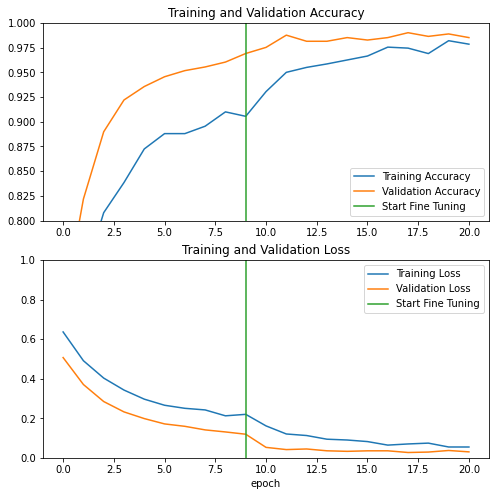

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 1s - loss: 0.0988 - accuracy: 0.9375

3/6 [==============>...............] - ETA: 0s - loss: 0.0631 - accuracy: 0.9688

5/6 [========================>.....] - ETA: 0s - loss: 0.0432 - accuracy: 0.9812

6/6 [==============================] - 0s 35ms/step - loss: 0.0370 - accuracy: 0.9844


Test accuracy : 0.984375


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0]
Labels:
 [0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0]


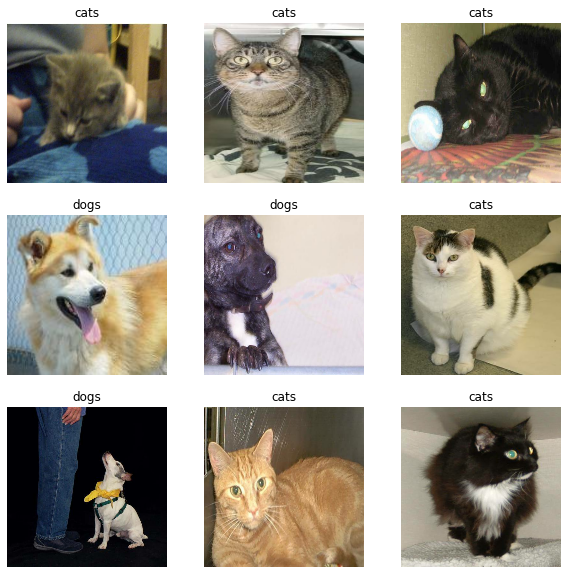

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
